# DSCI 100 - Project Final Report
Author: Gwynnie Guo

## Introduction

### Background
This DSCI 100 project will investigate a question that arises from examining a real data science project conducted by a [research group in UBC](https://plai.cs.ubc.ca/) that has set up a Minecraft server to collect data about how players navigate the world.

### Question
This project will attempt to answer this broad question: What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?

In order to answer this broad question, I will formulate a specific question from some of the variables in the dataset. My question will be: **Can variables played hours and age accurately predict whether or not the player will subscribe to a game-related newsletter, and what is the most accurate model to predict whether a player will subscribe?** 

### Data Description 
The dataset used for this project is the players.csv data, which is a list of all unique players, including data about each player. There are a total of 196 observations (players) and 7 variables. 

These are the columns in the dataset:

- `experience` - The experience level of each player
- `subscribe` - Whether or not the player is subscribed to a game-related newsletter
- `hashedEmail` - The unique email/code for the player
- `played_hours` - The number of hours played
- `name` - The name of the player
- `gender` - The gender of the player
- `Age` - The age of the player

The variables of interest for this project is `played_hours` and `Age` as the predictor variables and `subscribe` as the response variables. This project could have also used `experience` and `gender` as predictor variables but because they seem to factor datatype variables, it is more difficult to convert them into numerically encoded variables to become quantitative predictors.

## Methods & Results

To see whether played hours and/or age can predict whether or not the player will subscribe to a game-related newsletter, I will use the K-nearest neighbors classification model to evaluate the accuracy of the classifier model for `played_hours` and `Age` on whether or not the player is subscribed.

### Pre-processing and exploratory data analysis

First, I will load the dataset, preprocess the data, and engage in exploratory data analysis by visualizing the relationship between `played_hours` and `Age` on whether or not the player is subscribed.

In [1]:
# Run this cell before continuing to load all the necessary packages 
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
set.seed(0608) # for randomization and reproducibility

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
# Read and load the dataset 
players <- read_csv("data/players.csv")
players

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


*figure 1*

#### Cleaning and tidying the data
The variable `subscribe` is currently a logical datatype and we need to convert it to a factor datatype to make it categorical.

There are also missing data for the players dataset. Since there are not too many NAs in the dataset, we can drop them in the datast.

In [3]:
# Clean up the data by including the two predictor variables and response variable
# Converting the logical subscribe variable to the factor datatype
# Exclude the NAs in the dataset
players_clean <- players |> 
    select(subscribe, played_hours, Age) |>
    mutate(subscribe = as_factor(subscribe))|>
    mutate(subscribe = fct_recode(subscribe, "Yes" = "TRUE", "No" = "FALSE")) |>
    drop_na()

players_clean

subscribe,played_hours,Age
<fct>,<dbl>,<dbl>
Yes,30.3,9
Yes,3.8,17
No,0.0,17
⋮,⋮,⋮
No,0.3,22
No,0.0,17
No,2.3,17


*figure 2*

#### Visualizing the relationship between predictors and response variable


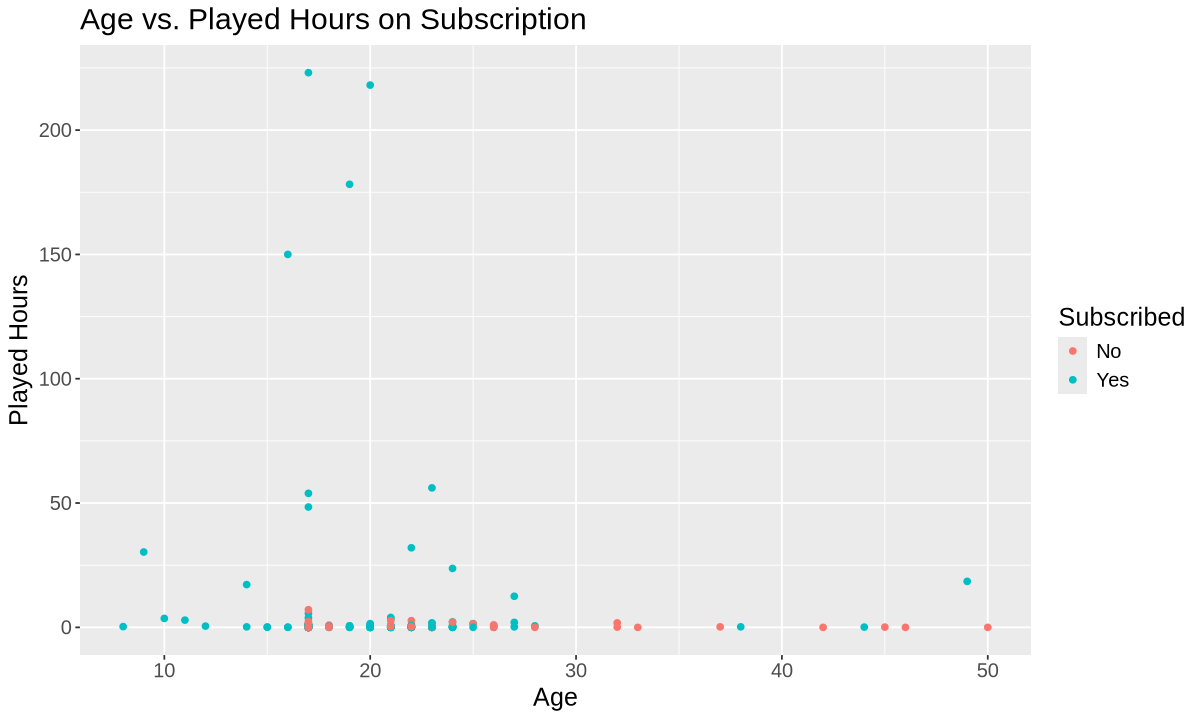

In [4]:
#plotting the training data
options(repr.plot.width = 10, repr.plot.height = 6)
players_visual <- ggplot(players_clean, aes(x = Age, y = played_hours, colour = subscribe)) +
                 geom_point() +
                 labs(x = "Age", y = "Played Hours",
                      color = "Subscribed", title = "Age vs. Played Hours on Subscription") +
                 theme(text = element_text(size = 15))


players_visual

*figure 3* 

This graph shows that players who are subscribed tend to have more played hours with a spread of ages. Those who are not subscribed have much lower played hours.

### Creating the K-Nearest Neighbors Classifer 

#### Splitting the data into training and testing set

Next, I will create the classifier model by splitting the dataset into a training and testing data set. I will use a 75% training and 25% testing split. 

In [5]:
players_split <- initial_split(players_clean, prop = 0.75, strata = subscribe)
players_train <- training(players_split)
players_test <- testing(players_split)

# View the data
glimpse(players_train)

Rows: 145
Columns: 3
$ subscribe    <fct> No, No, No, No, No, No, No, No, No, No, No, No, No, No, N…
$ played_hours <dbl> 0.0, 0.0, 0.1, 0.0, 1.4, 0.9, 0.0, 0.1, 0.2, 0.0, 0.0, 0.…
$ Age          <dbl> 22, 23, 18, 33, 25, 18, 42, 22, 37, 28, 21, 23, 17, 18, 1…


#### Training and tuning the classifier

Afterwards, I will find the best $k$ value for the $k$-nearest neighbours that will provide the highest accuracy in predictions. In the code below, I create a classifier and perform cross-validation to split the training data. 

In [6]:
# Recipe with standardized variables
players_recipe <- recipe(subscribe ~ played_hours + Age, data = players_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

# K-nearest neighbor model specification
players_knn <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

# Perform 5 fold-cross valdiation
players_vfold <- vfold_cv(players_train, v = 5, strata = subscribe)

k_vals <- tibble(neighbors = seq(from = 1, to = 50, by = 1))

# Create workflow
players_workflow <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(players_knn) |>
    tune_grid(resamples = players_vfold, grid = k_vals) |>
    collect_metrics()

players_accuracies <- players_workflow |>
    filter(.metric == "accuracy")

players_accuracies

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.4896388,5,0.05246919,Preprocessor1_Model01
2,accuracy,binary,0.4827422,5,0.04594416,Preprocessor1_Model02
3,accuracy,binary,0.6552545,5,0.03411140,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
48,accuracy,binary,0.7311494,5,0.005037841,Preprocessor1_Model48
49,accuracy,binary,0.7311494,5,0.005037841,Preprocessor1_Model49
50,accuracy,binary,0.7311494,5,0.005037841,Preprocessor1_Model50


*figure 4*

To decide which number of neighbors is best to use for the highest accuracy, I will begin by plotting the accuracy versus $K$

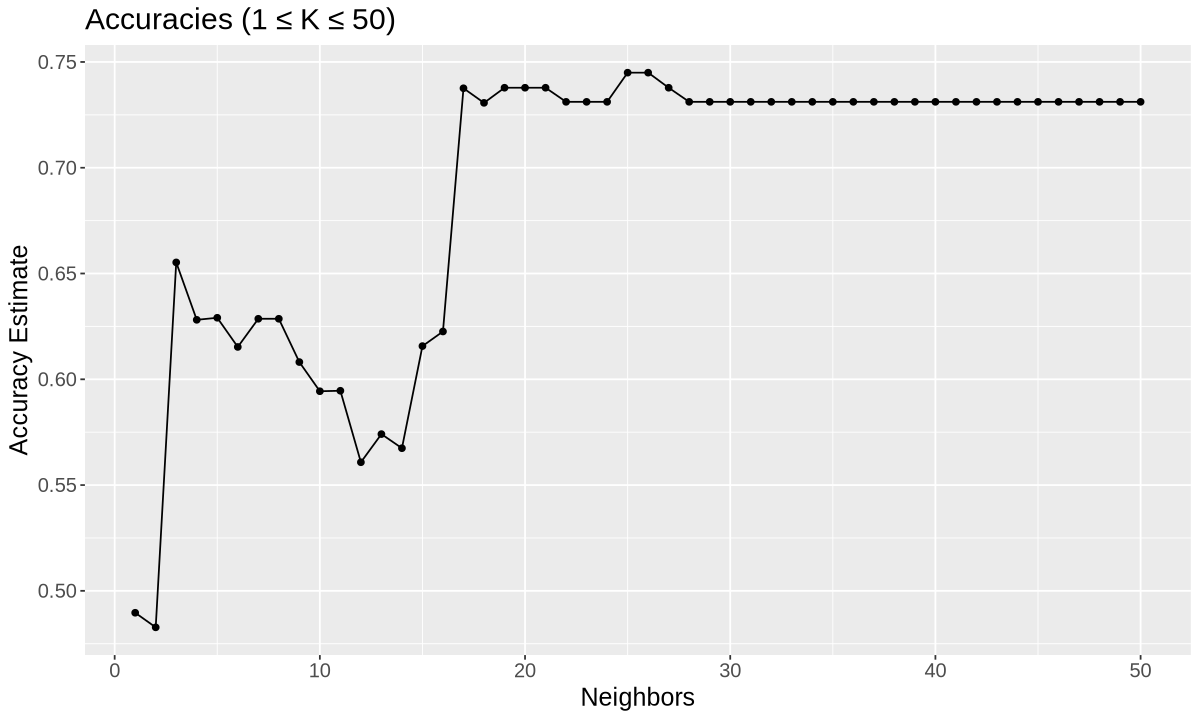

In [7]:
# Visualizing the accuracy of values for K
accuracy_versus_k <- ggplot(players_accuracies, aes(x = neighbors, y = mean)) + 
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate", title = "Accuracies (1 ≤ K ≤ 50)") +
    theme(text = element_text(size = 15))

accuracy_versus_k

*figure 5*

We can also obtain the number of neighbours with the highest accuracy by figuring out where the mean variable is the highest in the data frame.

In [8]:
# Finding the best k with the highest accuracy
best_k <- players_accuracies |>
    arrange(mean) |>
    tail(1) |>
    pull(neighbors) 

best_k

[1] 26

### Evaluating on the test set

Now that I have tuned the K-nearest neighbor classifier and set $K = 26$, I am done building the model and it is time to evaluate the quality of its predictions on the test data. 

We can take the same recipe but change the model specification using the best_k value. 

In [9]:
# K-nearest neighbor model specification with best K
players_knn <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
    set_engine("kknn") |>
    set_mode("classification")

# Create workflow
players_fit <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(players_knn) |>
    fit(data = players_train)

# Make predictions and evaluate the estimated accuracy of the best model on the test data
players_test_predictions <- predict(players_fit, players_test) |>
    bind_cols(players_test)

# Finds the estimated accuracy
players_test_predictions |>
    metrics(truth = subscribe, estimate = .pred_class) |>
    filter(.metric == "accuracy")

players_test_predictions

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.755102


.pred_class,subscribe,played_hours,Age
<fct>,<fct>,<dbl>,<dbl>
Yes,No,0,17
Yes,Yes,0,19
Yes,No,0,21
⋮,⋮,⋮,⋮
No,No,0.1,18
Yes,Yes,0.0,17
Yes,No,2.3,17


In [10]:
# Creates the confusion matrix, identifies the areas the model is weak at classifying
players_conf_mat <- players_test_predictions |>
    conf_mat(truth = subscribe, estimate = .pred_class)
players_conf_mat

players_levels <- players_test_predictions |> 
    pull(subscribe) |> 
    levels()
players_levels

# Computes the precision for the classifier
players_precision <- players_test_predictions |>
    precision(truth = subscribe, estimate = .pred_class, event_level = "second")
players_precision

# Computes the recall for the classifier
players_recall <- players_test_predictions |>
    recall(truth = subscribe, estimate = .pred_class, event_level = "second")
players_recall

          Truth
Prediction No Yes
       No   1   0
       Yes 12  36

[1] "No"  "Yes"

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,0.75


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,1


*figure 6, 7, 8* 

The classifier was 75.51% accurate and correctly labeled 1 observation as "No" to being subscribed and correctly labeled 36 observations as "Yes" to being subscribed. The classifier also made a certain type of repeat mistake; it labeled 12 observations as "Yes" to being subscribed when they were not subscribed, but it did not incorrectly label subscribers as non-subscribers.

This means that the classifier is more prone to predicting "Yes" to whether or not a player is subscribed and it rarely predicts "No" (only once). Precision is crucial to prevent false positives, which is determining when a player is a subscribed but actually isn't, and there is an estimated precision of 75%. Recall is crucial to prevent missed detections of the positive label ("Yes"), and there is an estimated recall of 100%, which means there are no missed labeling of "Yes".

#### Comparing to majority classifier

We can assess the relative accuracy of the classifier above by comparing it to the majority classifier, which always guesses the majority class label in the dataset. 

In [11]:
players_proportions <- players_train |>
    group_by(subscribe) |>
    summarize(n = n()) |>
    mutate(percent = 100*n/nrow(players_train)) 

players_proportions

subscribe,n,percent
<fct>,<int>,<dbl>
No,39,26.89655
Yes,106,73.10345


A "Yes" to being subscribed represents the majority of the training data with 73.1% of all results. The accuracy from our classifer was 75.51%, which just barely has a better accuracy than the majority classifier. Therefore, this means that the classifier built with the knn classification model did just barely better for accuracy, and it means that the predictor variables have some, though slight, influence on the response variable.

## Discussion

### Summary of Findings


future: changing the proportion of the training and testing data to 80/20 split so we have more training data to do the cross-validation
